# Imports

In [10]:
import os
import sys
import json
import geopandas as gpd
import xarray as xr
import numpy as np
import time

In [4]:
# go up until we are in the project base directory
base_dir = os.getcwd()
while base_dir.split('/')[-1] != 'provide':
    base_dir = os.path.normpath(os.path.join(base_dir, '..'))

# add paths for tools and data
things_to_add = ['general_tools', 'aggregation_tools', 'general_data_for_aggregation']
for thing in things_to_add:
    sys.path.append(os.path.join(base_dir, thing))

from general_tools import check_if_notebook, mkdir
from oggm_result_filepath_and_realisations import scenarios_mesmer
from aggregation_plots import plot_map, plot_timeseries, plot_unavoidable_risk

In [5]:
# Use this to conditionally execute tests/debugging
if check_if_notebook():
    is_notebook = True
else:
    is_notebook = False

# define inputs

In [6]:
resolution_dir = 'resolution_1_deg'
input_folder = 'aggregated_data'
output_folder = 'aggregated_result_plots'

In [7]:
preprocess_country_dict_outpath = os.path.join(base_dir, 'countries', resolution_dir)

with open(os.path.join(preprocess_country_dict_outpath, "preprocessed_country_grids.json"), 'r') as f:
    country_structure_dict = json.load(f)

In [8]:
# open shapefile of country for plot
countries_data_dir = os.path.join(base_dir, 'countries', 'data')
countries_file = 'ne_10m_admin_0_countries_deu_CA.shp'
gdf_countries = gpd.read_file(os.path.join(countries_data_dir, countries_file))
name_col_countries = 'ADM0_A3_DE'

# plot for all countries and scenarios

In [7]:
def plot_scenario_results_country(country_name, scenario, input_folder, output_folder):
    plot_output_folder = os.path.join(output_folder, country_name)
    mkdir(plot_output_folder)
    country = gdf_countries[gdf_countries[name_col_countries] == country_name]

    plot_map(country, country_name, scenario, input_folder, figsize=(12, 7),
             save_plot=plot_output_folder)

    plot_timeseries(country_name, scenario, input_folder, figsize=(5, 9),
                    save_plot=plot_output_folder)

def plot_unavoidable_risk_for_all_scenarios(country_name, scenarios, input_folder,
                                            output_folder):
    plot_output_folder = os.path.join(output_folder, country_name)
    mkdir(plot_output_folder)

    plot_unavoidable_risk(country_name, scenarios, input_folder, figsize=(5, 15),
                          save_plot=plot_output_folder)

## testing in notebook

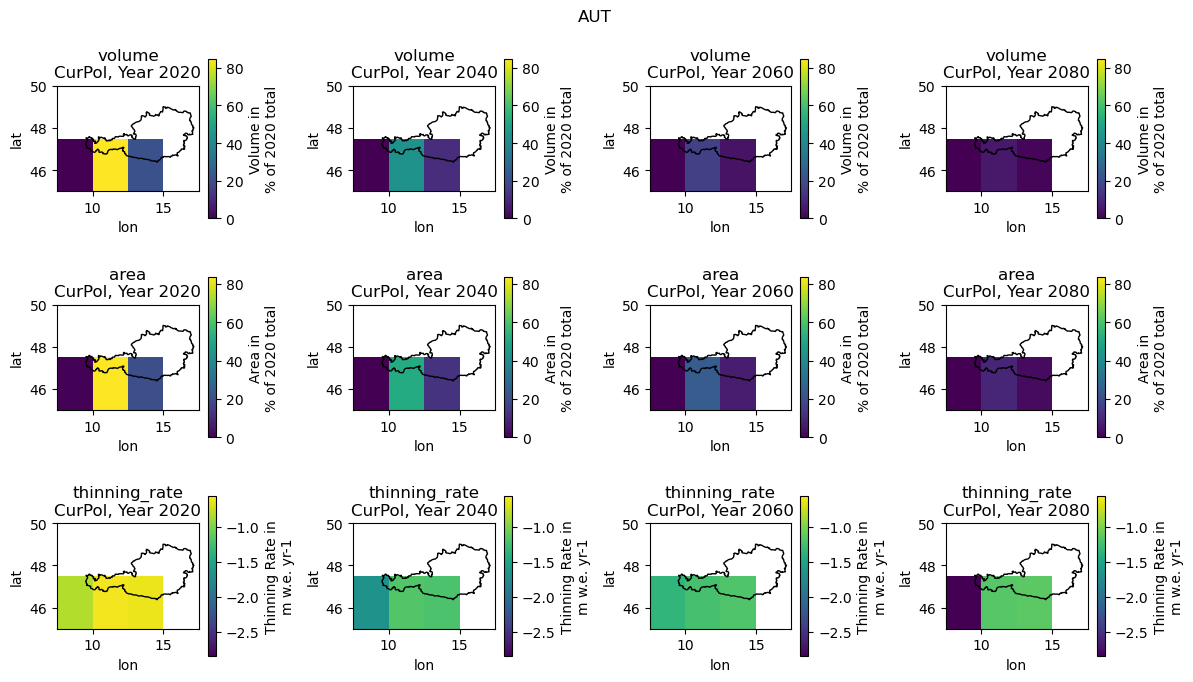

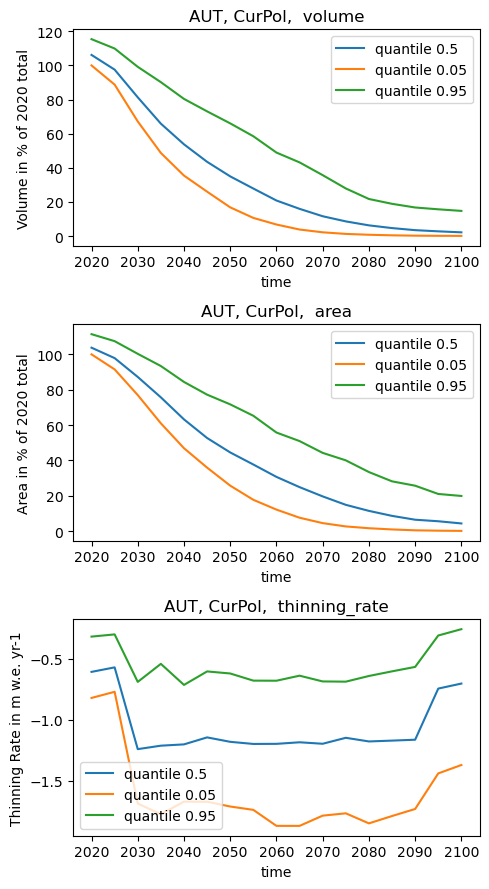

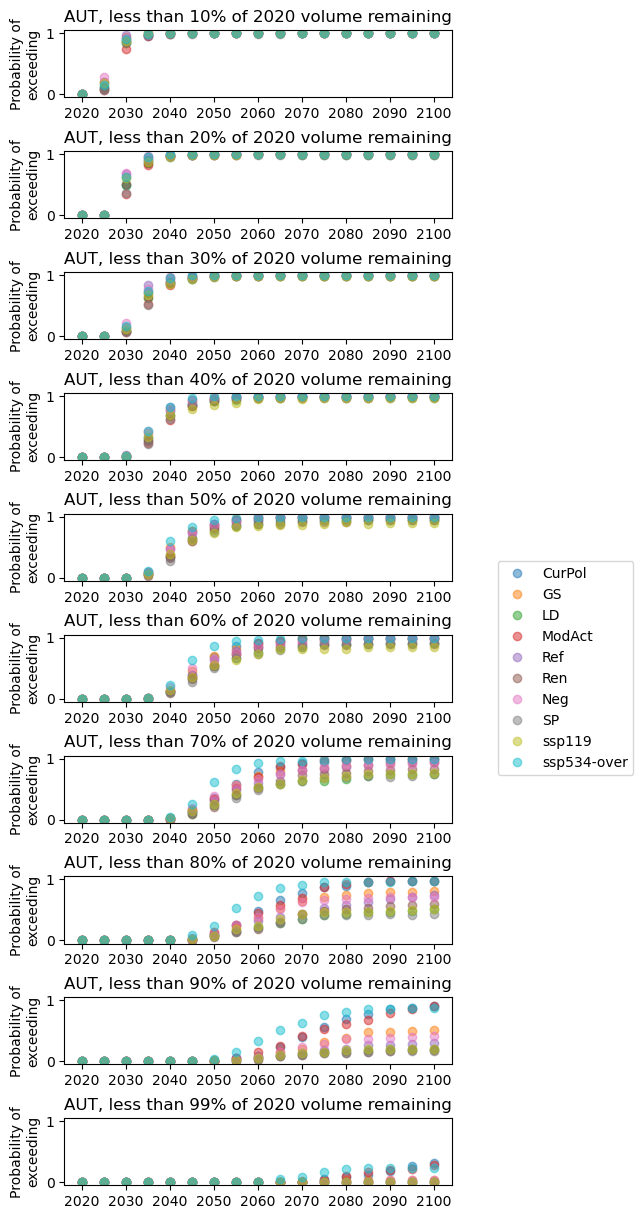

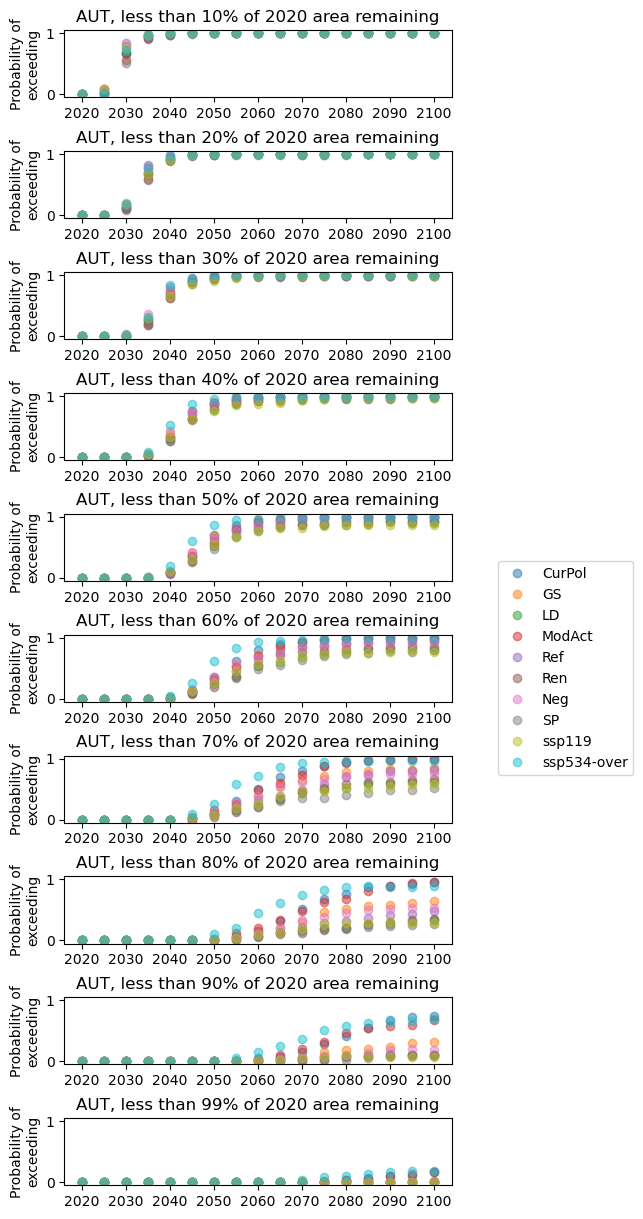

In [8]:
if is_notebook:
    test_output_folder = 'aggregated_result_plots_test'
    mkdir(test_output_folder)

    test_country = 'AUT'
    test_scenario = scenarios_mesmer[0]

    plot_scenario_results_country(test_country, test_scenario,
                                  input_folder, test_output_folder)

    plot_unavoidable_risk_for_all_scenarios(test_country, scenarios_mesmer,
                                            input_folder, test_output_folder)

## code for cluster

In [9]:
if not is_notebook:
    # save results on cluster and copy at the end in run_slurm-file
    working_dir_cluster = os.environ.get('OGGM_WORKDIR', None)

    output_folder = os.path.join(working_dir_cluster,
                                 output_folder)
    mkdir(output_folder)

    start_time = time.time()
    for country in country_structure_dict:
        print(f'Start plotting {country}:')
        print(f'    unavoidable risk ({time.time() - start_time:.1f} s)')
        plot_unavoidable_risk_for_all_scenarios(country, scenarios_mesmer,
                                                input_folder, output_folder)
        for scenario in scenarios_mesmer:
            print(f'    {scenario} plots ({time.time() - start_time:.1f} s)')
            plot_scenario_results_country(country, scenario,
                                          input_folder, output_folder)

# count files of each country

In [ ]:
if is_notebook:
    nr_files_ref = None
    for country in country_structure_dict:
        path_country = os.path.join(output_folder,
                                    country)
        nr_files_country = len([file for file in os.listdir(path_country)
                                if os.path.isfile(file)])
        if nr_files_ref is None:
            nr_files_ref = nr_files_country
        elif nr_files_ref != nr_files_country:
            print(f'!!!{country} {nr_files_country} files, reference {nr_files_ref}!!!')
        else:
            print(f'{country} {nr_files_country} files')

# check output files for consistancy

In [11]:
if is_notebook:
    # same ref values for each scenario?
    for country in country_structure_dict:
        print(f'Checking ref values {country}')
        ref_volume = None
        ref_area = None
        for scenario in scenarios_mesmer:
            with xr.open_dataset(
                os.path.join(input_folder,
                             country,
                             f'{country}_{scenario}_timeseries.nc')) as ds_time:
                if ref_volume is None:
                    ref_volume = ds_time.volume.reference_2020_km3
                else:
                    if not np.isclose(ds_time.volume.reference_2020_km3,
                                      ref_volume,
                                      #rtol=0.01,
                                      #atol=30
                                     ):
                        print(f'{country}/{scenario}: volume NOT close to reference '
                              f'(given {ds_time.volume.reference_2020_km3:.1f}, '
                              f'reference {ref_volume:.1f})')

                if ref_area is None:
                    ref_area = ds_time.area.reference_2020_km2
                else:
                    if not np.isclose(ds_time.area.reference_2020_km2,
                                      ref_area,
                                      #rtol=0.01,
                                      #atol=80
                                     ):
                        print(f'{country}/{scenario}: area NOT close to reference '
                              f'(given {ds_time.area.reference_2020_km2:.1f}, '
                              f'reference {ref_area:.1f})')

    # are map values 2020 add up to 100%
    for country in country_structure_dict:
        print(f'Checking map sum 2020 for {country}')
        for scenario in scenarios_mesmer:
            with xr.open_dataset(
                        os.path.join(input_folder,
                                     country,
                                     f'{country}_{scenario}_map.nc')) as ds_map:
                for var in ['volume', 'area']:
                    for quant in ds_map['quantile']:
                        map_sum = ds_map.loc[{'time': 2020, 'quantile':quant}]['volume'].sum().values
                        if not np.isclose(map_sum, 100):
                            if np.isclose(map_sum, 0):
                                print(f'  {country} is 0 ({scenario}, {var}, {quant.values})')
                            else:
                                print(f'Map 2020 adds not up to 100, only {map_sum} '
                                      f'({country}, {scenario}, {var}, {quant.values})')

Checking ref values CHL
Checking ref values CHN
Checking ref values DEU
Checking ref values NPL
Checking ref values UZB
Checking ref values FRA
Checking ref values AUT
Checking ref values BOL
Checking ref values CAN
Checking ref values TUR
Checking ref values AFG
Checking ref values PER
Checking ref values TJK
Checking ref values NZL
Checking ref values IND
Checking ref values COL
Checking ref values KAZ
Checking ref values ALB
Checking ref values GRL
Checking ref values MMR
Checking ref values ISL
Checking ref values CHE
Checking ref values SVN
Checking ref values MNE
Checking ref values NOR
Checking ref values MNG
Checking ref values ITA
Checking ref values ESP
Checking ref values MEX
Checking ref values KGZ
Checking ref values ECU
Checking ref values SWE
Checking ref values ARG
Checking ref values RUS
Checking ref values BTN
Checking ref values USA
Checking ref values PAK
Checking ref values IRN
Checking ref values GEO
Checking ref values VEN
Checking map sum 2020 for CHL
Checking m